# COM3025 Coursework

> Dylan Parker, Harry Payne, Zeya Rabani, James Wright







---


## Import Dataset


---



In [1]:
import numpy as np
from PIL import Image
import h5py
import os
from IPython.display import HTML, display

# This is for displaying the progress bar while importing data
def progress(value, max=100):
    return HTML("""
        Importing Files:
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Clone dataset if not already done
![[ -d COM3025 ]] || git clone https://github.com/jw01324/COM3025.git
directory = "./COM3025/Brain Tumor Dataset/Files/"
numberOfFiles = len(os.listdir(directory))

# Create dataset arrays
# Look at README for data structure
labels = np.empty((numberOfFiles,), float) 
images = np.empty((numberOfFiles, 512,512), float) 
tumorBorders = np.empty((numberOfFiles, ), dtype=object)
tumorMask = np.empty((numberOfFiles, 512,512), int) 

# Start showing progress bar
out = display(progress(0, numberOfFiles), display_id=True)

for i,filename in enumerate(os.listdir(directory)):
  # Update progress bar
  out.update(progress(i, numberOfFiles))
  
  with h5py.File(directory + filename, 'r') as file:
    labels[i] = file['cjdata']['label'][()][0][0]
    if len(file['cjdata']['image'][()]) == 512:
      images[i] = np.flipud(np.rot90(file['cjdata']['image'][()]))
      tumorMask[i] = np.flipud(np.rot90(file['cjdata']['tumorMask'][()]))
      tumorBorders[i] = file['cjdata']['tumorBorder'][()][0]
    else: # Some images are 256 so repeat each pixel
      images[i] = np.repeat(np.repeat(np.flipud(np.rot90(file['cjdata']['image'][()])), 2, axis=1), 2, axis=0)
      tumorMask[i] = np.repeat(np.repeat(np.flipud(np.rot90(file['cjdata']['tumorMask'][()])), 2, axis=1), 2, axis=0)
      tumorBorders[i] = [x*2 for x in file['cjdata']['tumorBorder'][()][0]]



---


# Resizing Images


---


*Note: this segment should only ever  be run once, otherwise the tumorMask data will be 
downsized multiple times. It takes a similar amount of time to run as the previous segment (~30s).*

In [2]:
from skimage.transform import resize
from skimage.measure import block_reduce
from copy import deepcopy

#defining the new size of each image
newSize = (128, 128)

#creating empty arrays to hold the resized datasets
images_rs = np.empty((numberOfFiles, newSize[0], newSize[1]), float) 
tumorMask_rs = np.zeros((numberOfFiles, newSize[0], newSize[1]), int)
#create a deepcopy of the tumorBorders  
tumorBorders_rs = deepcopy(tumorBorders)

# Start showing progress bar
out = display(progress(0, numberOfFiles), display_id=True)

#resizing the data and storing it in the new array
for i in range(0,numberOfFiles):
  # Update progress bar
  out.update(progress(i, numberOfFiles))

  #resize each image to the defined new size
  images_rs[i] = resize(images[i], newSize)  

  #reduce the mask to the new size through pooling, this finds the mean between 16 datapoints to be reduced into one
  tumorMask_rs[i] = block_reduce(tumorMask[i], (4,4), np.mean)
  #round the values as the mask only reads 0s and 1s
  tumorMask_rs[i] = np.around(tumorMask_rs[i])

  try: #for arrays formatted as per numpy.array
    tumorBorders_rs[i] = tumorBorders_rs[i]/4
  except TypeError: #for arrays not formatted similarly to numpy arrays, this is the case for some of the arrays within the dataset
    for j in range (len(tumorBorders_rs[i])):
      tumorBorders_rs[i][j] = tumorBorders_rs[i][j]/4



---


# Displaying Resized Images


---
*Note: The two selected images contain tumorBorders of different array types. 0 = numpy, 323 = standard array.*


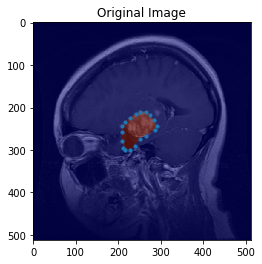

Original Dataset Size: (3064, 512, 512)


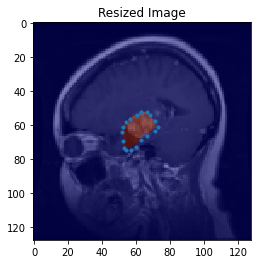

New Dataset Size: (3064, 128, 128)


In [3]:
import matplotlib.pyplot as plt

tumorBordersX = tumorBorders[0][::2]
tumorBordersY = tumorBorders[0][1::2]
tumorBordersX_rs = tumorBorders_rs[0][::2]
tumorBordersY_rs = tumorBorders_rs[0][1::2]

plt.figure()
plt.title("Original Image")
plt.imshow(images[0], 'gray', interpolation='none')
plt.imshow(tumorMask[0], 'jet', interpolation='none', alpha=0.5)
plt.scatter(tumorBordersX, tumorBordersY, s=10)
plt.show()

print("Original Dataset Size: " + str(images.shape))

plt.figure()
plt.title("Resized Image")
plt.imshow(images_rs[0], 'gray', interpolation='none')
plt.imshow(tumorMask_rs[0], 'jet', interpolation='none', alpha=0.5)
plt.scatter(tumorBordersX_rs, tumorBordersY_rs, s=10)
plt.show()

print("New Dataset Size: " + str(images_rs.shape))

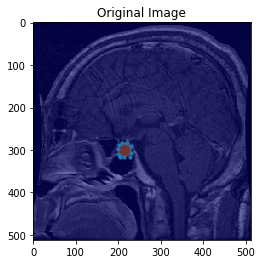

Original Dataset Size: (3064, 512, 512)


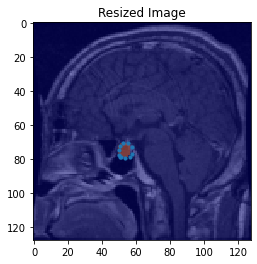

New Dataset Size: (3064, 128, 128)


In [4]:
import matplotlib.pyplot as plt

tumorBordersX = tumorBorders[323][::2]
tumorBordersY = tumorBorders[323][1::2]
tumorBordersX_rs = tumorBorders_rs[323][::2]
tumorBordersY_rs = tumorBorders_rs[323][1::2]

plt.figure()
plt.title("Original Image")
plt.imshow(images[323], 'gray', interpolation='none')
plt.imshow(tumorMask[323], 'jet', interpolation='none', alpha=0.5)
plt.scatter(tumorBordersX, tumorBordersY, s=10)
plt.show()

print("Original Dataset Size: " + str(images.shape))

plt.figure()
plt.title("Resized Image")
plt.imshow(images_rs[323], 'gray', interpolation='none')
plt.imshow(tumorMask_rs[323], 'jet', interpolation='none', alpha=0.5)
plt.scatter(tumorBordersX_rs, tumorBordersY_rs, s=10)
plt.show()

print("New Dataset Size: " + str(images_rs.shape))



---


# Reshaping the images


---
*Note: This adds an extra dimension to the image*



In [5]:
images_rs /= 255 # Get all values 0 < ? < 1         
images_rs = np.expand_dims(images_rs, axis=3) # Adds a dimension to images for Conv2D
print("Shape of train images", images_rs.shape, "containing", images_rs.dtype)
print("Shape of train labels", labels.shape, "containing", labels.dtype)

Shape of train images (3064, 128, 128, 1) containing float64
Shape of train labels (3064,) containing float64




---


# Prepare for training


---



In [0]:
#I have adapted this section so that the model is split up 3 times (training, testing, and validation)
#where the validation set is an unseen set of data so that the model can be checked for overfitting.
#This section selects 1715 images for training, 736 for testing, and 613 for validation

#choosing the amount of validation data to hold back
validationSplit = (len(images)*8)//10

#choosing the split for the training and testing dataset (using the validation split point as the max)
splitIndex = (validationSplit*7)//10

x_train = images_rs[:splitIndex]
x_test = images_rs[splitIndex:validationSplit]
x_validate = images_rs[validationSplit:]

labels = labels.astype(int)
one_hot_labels = np.zeros((labels.size, labels.max()))
one_hot_labels[np.arange(labels.size), labels -1] = 1

y_train = one_hot_labels[:splitIndex]
y_test = one_hot_labels[splitIndex:validationSplit]
y_validate = one_hot_labels[validationSplit:]



---


# Training the model


---
*Note: Used to classify each tumour*


In [11]:
from IPython.display import Image
import matplotlib.pyplot as plt
import keras
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer
from keras.layers import Conv2D, MaxPooling2D

batch_size = 64
epochs = 20

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128,128,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(32, 32)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Image(model_to_dot(model).create(prog='dot', format='png'))
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
activation_54 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_55 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)              

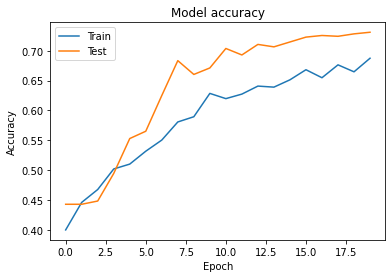

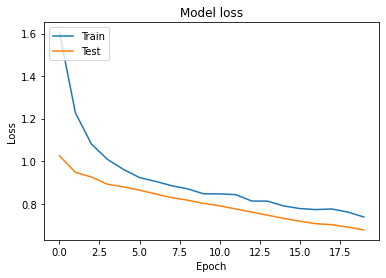

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



---


# Validating the model


---


In [13]:
#evaluating the loss(error) and accuracy for the validation dataset (unseen data from the dataset)
scores = model.evaluate(x_validate, y_validate, verbose=0)
print("Loss: " + "{:.2f}".format(scores[0] * 100) + "%")
print("Accuracy: " + "{:.2f}".format(scores[1] * 100) + "%")

Loss: 68.36%
Accuracy: 72.27%




---


# Identifying Tumour


---
*Note: Identified through use of the cut up image and mask*


In [14]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image
import time

%matplotlib inline

model = ResNet50(weights='imagenet')

segments_searched = 0
step = 32
#arrimg = np.array(image_rgb)
#print(image_rgb)
for y in range(0,128,step):
    for x in range(0,128,step):
        
        cropped = images_rs[i][y:y+step][x:x+step]

        stretched = Image.fromarray(cropped)
        stretched = stretched.resize((224,224), Image.ANTIALIAS)
        stretched = np.array(stretched)
        stretched = np.expand_dims(stretched, axis=0)
        stretched = stretched.astype(np.float64)
        stretched = preprocess_input(stretched)
        
        preds = model.predict(stretched)
        top3 = str(decode_predictions(preds, top=3)[0])
        segments_searched += 1
        
        #print(preds)
        if "1" in top3 or "2" in top3 or "3" in top3:
            #print(top3)
            #print("Found a tumour")
            plt.figure()
            plt.imshow(cropped)
        
print("Total segments searched", segments_searched)

TypeError: ignored



---


# Display images


---



In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

def test():
  i = randint(0, len(images))

  tumorBordersX = tumorBorders[i][::2]
  tumorBordersY = tumorBorders[i][1::2]

  class_name = ""
  if (labels[i] == 1.0):
    class_name = "Meningioma Tumour"
  elif (labels[i] == 2.0):
    class_name = "Glioma Tumour"
  elif (labels[i] == 3.0):
    class_name = "Pituitary Tumour"

  plt.figure()
  plt.title("Class id: " + str(labels[i]) + " || Class name: " + class_name)
  plt.imshow(images[i], 'gray', interpolation='none')
  plt.imshow(tumorMask[i], 'jet', interpolation='none', alpha=0.5)
  plt.scatter(tumorBordersX, tumorBordersY, s=10)
  plt.show()

for i in range (0, 3):
  test()